In [1]:
import platform
platform.python_version()

'3.7.11'

In [14]:
# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import circularMask
from pepe.simulate import genSyntheticResponse
from pepe.analysis import singleParticleForceBalance

# Compare against Olivier's code
sys.path.append('/home/jack/workspaces/jupyter-workspace/pegs_py')
import StressEngineC.StressEngineC as SEC

# Compare against Jonathan's code
import matlab.engine
import matlab
eng = matlab.engine.start_matlab()
sys.path.append('/home/jack/workspaces/matlab-workspace/PEGS/')
import numpy as np

import numba
from PIL import Image

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

# For timing
import time

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [15]:
# Create a fake particle
radius = 200

imageShape = (500, 500)
center = np.array([imageShape[0]/2., imageShape[1]/2.])

cMask = circularMask(imageShape, center, radius)[:,:,0]

# Find all points inside the particle (on the grid)
gridPoints = np.transpose(np.where(cMask > 0))
# And relative to the center of the particle
particlePoints = gridPoints - center

# Setup physical parameters
# We have to be very careful about types, since Olivier's method is written
# in native C and compiled with Cython, which does not have the best
# type-conversion interface (especially compared to numba :) )
fSigma = 10.
pxPerMeter = 1000.
brightfield = int(False)

forceArr = np.array([1, 1], dtype=np.double) # [N]
betaArr = np.array([0, -np.pi], dtype=np.double) # [rad]
alphaArr = np.array([0, 0], dtype=np.double) # [rad]

mForceArr = matlab.double(list(forceArr)) # [N]
mBetaArr = matlab.double(list(betaArr)) # [rad]
mAlphaArr = matlab.double(list(alphaArr)) # [rad]

z = len(forceArr)

In [10]:
# Time how long the genSyn method takes
%timeit genSyntheticResponse(forceArr, alphaArr, betaArr, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape)

34.1 ms ± 414 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Jack's finished in: 0.036721967000630684 seconds
Olivier's finished in: 0.2181910519993835 seconds
Jonathan's finished in: 0.6052829649997875 seconds


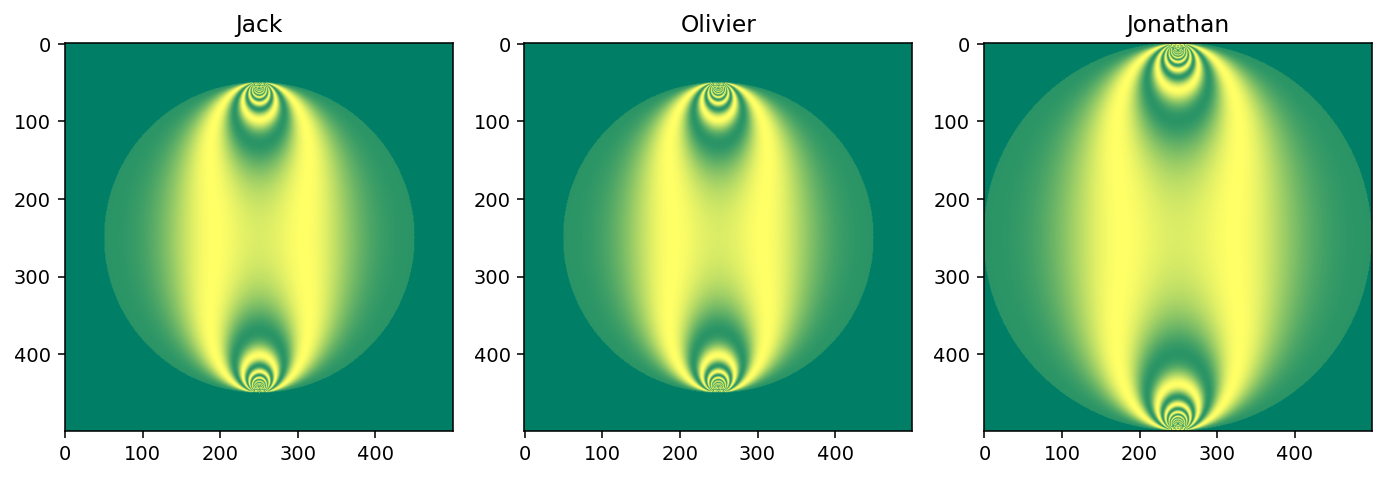

In [11]:
intensityArr = np.zeros([3, imageShape[0], imageShape[1]], dtype=np.float64)

startTime = time.perf_counter()
intensityArr[0] = genSyntheticResponse(forceArr, alphaArr, betaArr, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape)
print(f'Jack\'s finished in: {time.perf_counter() - startTime} seconds')
    
startTime = time.perf_counter()
for i in range(len(gridPoints)):
    intensityArr[1,gridPoints[i,0],gridPoints[i,1]] = SEC.StressEngineC(particlePoints[i,1]/pxPerMeter, particlePoints[i,0]/pxPerMeter, z, forceArr, alphaArr, betaArr, fSigma, radius/pxPerMeter, brightfield)
print(f'Olivier\'s finished in: {time.perf_counter() - startTime} seconds')

startTime = time.perf_counter()
# Note the transpose, since we want to flip the format to be [y,x] instead of [x,y]
intensityArr[2] = np.transpose(eng.joForceFunc(z, mForceArr, mAlphaArr, mBetaArr, fSigma, radius/pxPerMeter, int(imageShape[0]), 1))
print(f'Jonathan\'s finished in: {time.perf_counter() - startTime} seconds')

    
intensityArr[intensityArr == 0] = -.2
fig, ax = plt.subplots(1, 3, figsize=(10,4))

for i in range(3):
    ax[i].imshow(intensityArr[i], cmap=plt.get_cmap('summer'))
    
ax[0].set_title('Jack')
ax[1].set_title('Olivier')
ax[2].set_title('Jonathan')

fig.tight_layout()
plt.show()

In [12]:
# If all three of the objects are the same, this matrix should be all zeros
np.subtract.outer(np.sum(intensityArr, axis=(-1, -2)), np.sum(intensityArr, axis=(-1, -2)))

array([[ 0.00000000e+00,  8.12024777e-01, -4.72836769e+04],
       [-8.12024777e-01,  0.00000000e+00, -4.72844889e+04],
       [ 4.72836769e+04,  4.72844889e+04,  0.00000000e+00]])

In [23]:
radius = 240
imageSize = np.array([500, 500])
steps = 2000
fps = 60

images = [[] for i in range(steps)]

for i in range(steps):
    f = np.array([.05, .05]) * i
    a = np.array([0., 0.])
    b = np.array([0., -np.pi])
    imageArr = np.zeros((imageSize[0], imageSize[1], 3), dtype=np.uint8)
    imageArr[:,:,0] = np.uint8(255*genSyntheticResponse(f, a, b, fSigma, radius, pxPerMeter, imageSize=imageSize))
    images[i] = Image.fromarray(imageArr)
    
images[0].save('calibration.gif', save_all=True, append_images=images[1:], duration=fps, optimize=True, loop=1)

[1. 1.]
[ 0.17079633 -0.17079633]
[[1.5707963267948966,-1.5707963267948966]]


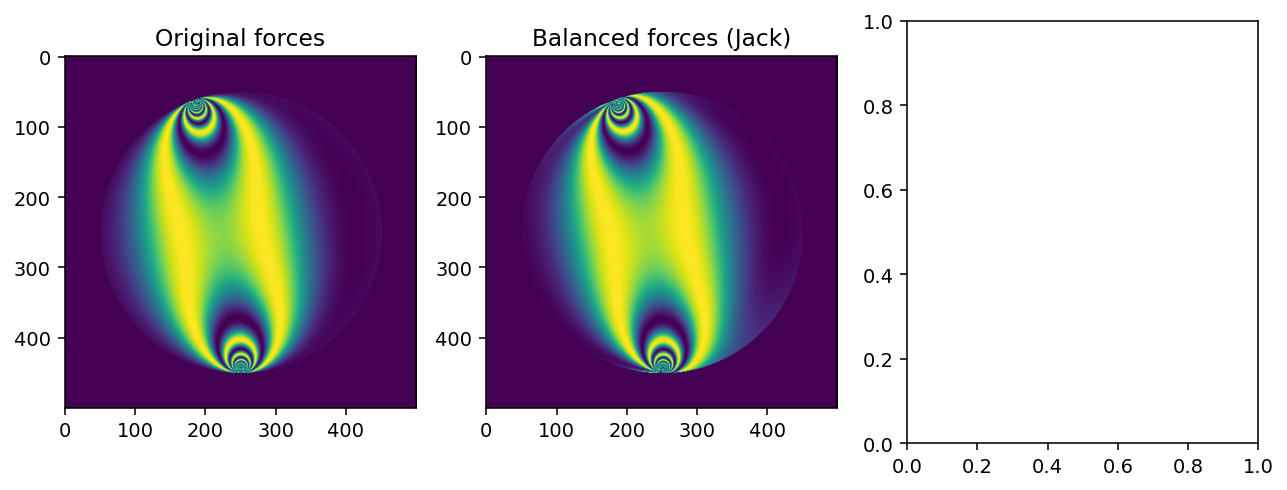

In [27]:
# Now test that the force balancing works

forceArr = np.array([1., 1.], dtype=np.double) # [N]
betaArr = np.array([0., -2.8], dtype=np.double) # [rad]
alphaArr = np.array([0., 0.], dtype=np.double) # [rad]

mForceArr = matlab.double(list(forceArr)) # [N]
mBetaArr = matlab.double(list(betaArr)) # [rad]
mAlphaArr = matlab.double(list(alphaArr)) # [rad]

fig, ax = plt.subplots(1, 3, figsize=(11,4))

pepeResponse = genSyntheticResponse(forceArr, alphaArr, betaArr, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape)

pepeBalancedForce, pepeBalancedAlpha = singleParticleForceBalance(forceArr, alphaArr, betaArr)
pepeBalancedResponse = genSyntheticResponse(pepeBalancedForce, pepeBalancedAlpha, betaArr, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape)

print(pepeBalancedForce)
print(pepeBalancedAlpha)

res = eng.forceBalance(mForceArr, mBetaArr, mAlphaArr)

print(res)

ax[0].imshow(pepeResponse)
ax[0].set_title('Original forces')

ax[1].imshow(pepeBalancedResponse)
ax[1].set_title('Balanced forces (Jack)')


plt.show()